# SPAD-FFS on Bright-Eyes TTM

In [1]:
%pylab inline
import pandas
from tqdm import tqdm 

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import math
import h5py
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import copy
import os

In [3]:
import libttp.ttp as ttp

In [4]:
from spad_tools import *
from spad_fcs import *

In [5]:
CHANNELS=25

sysclk_MHz=240.         # FPGA system clock (MHz)
laser_MHz=80.           # Laser repetition rate (MHz)
laser_factor=1          # Adimensional number to account for laser actual repetiton frequency
nchannel = CHANNELS     # Number of active channels
kC4=43                  # Time width of TCSPC histogram bin (picoseconds

In [6]:
filenameHDF5="/YOURPATH/09_cell2_FCS.h5"

In [7]:
laser_MHz=laser_MHz*laser_factor
laser_Hz=laser_MHz*10**6
max_counter=2**16-1
sysclk_ps=1000000./sysclk_MHz #ps
print("SysClk ps:", sysclk_ps)
laser_ps=1000000./laser_MHz #ps
print("LaserClk ps:", laser_ps)
ratio=sysclk_MHz/laser_MHz
sysclk_ps=1e6/sysclk_MHz
laser_ps=1e6/laser_MHz
nbins=int(round(laser_ps/kC4))

SysClk ps: 4166.666666666667
LaserClk ps: 12500.0


## Import data YG beads

.h5 file name

Load data, channels = number of channels to load, typically 25 or 49

In [8]:
data=loadATimesData(filenameHDF5, channels=nchannel)

  0%|                                                    | 0/25 [00:02<?, ?it/s]


ch_L calculated from ch_0


100%|███████████████████████████████████████████| 25/25 [01:05<00:00,  2.60s/it]


Loading channel 0
Loading channel 1
Loading channel 2
Loading channel 3
Loading channel 4
Loading channel 5
Loading channel 6
Loading channel 7
Loading channel 8
Loading channel 9
Loading channel 10
Loading channel 11
Loading channel 12
Loading channel 13
Loading channel 14
Loading channel 15
Loading channel 16
Loading channel 17
Loading channel 18
Loading channel 19
Loading channel 20
Loading channel 21
Loading channel 22
Loading channel 23
Loading channel 24


As an example, show the data array for channel 0. The first column shows for each photon the macrotimes, the second the microtimes. Expressed in ps.

In [9]:
data.det0

array([[5.72937500e+08, 6.74948754e+03],
       [6.89300000e+08, 6.61591475e+03],
       [7.33004167e+08, 2.01833940e+03],
       ...,
       [9.59736680e+13, 6.50055957e+03],
       [9.59737517e+13, 6.94256772e+02],
       [9.59737895e+13, 6.38623275e+03]])

Macrotimes and microtimes are expressed in ps.

In [10]:
data.macrotime = 1e-12
data.microtime = 1e-12

Plot parameters

In [11]:
fontSize = 20
plt.rcParams.update({'font.size': fontSize})
plt.style.use("seaborn-colorblind")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['mathtext.rm'] = 'Arial'
lineW = 1

## Plot intensity traces

Measurement duration: 96 s


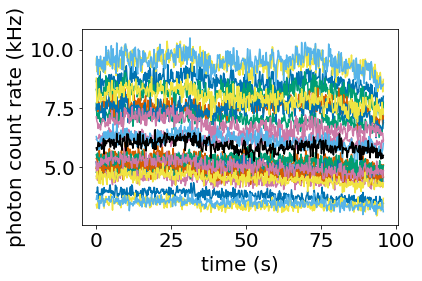

In [12]:
Ndet = nchannel # number of channels to plot
totTime = data.macrotime * np.max(data.det10[:,0])
print("Measurement duration: " + '{:.0f}'.format(totTime) + " s")

# plot intensity trace
Lseg = 0.2
maxseg = int(np.floor(totTime / Lseg))

plt.figure()
for det in range(Ndet):
    if det != 10:
        time = getattr(data, "det" + str(det))[:,0]
        timeAbs = time * data.macrotime
        [Itrace, timeBins] = np.histogram(timeAbs, maxseg)
        plt.plot(timeBins[0:-1], Itrace[0:] / (timeBins[2] - timeBins[1]) / 1e3)

# channel 10
time = getattr(data, "det10")[:,0]
timeAbs = time * data.macrotime
[Itrace, timeBins] = np.histogram(timeAbs, maxseg)
plt.plot(timeBins[0:-1], Itrace[0:] / (timeBins[2] - timeBins[1]) / 1e3, color='black')
#plt.plot(1e-3*lifetimeBins, histD[:,1], linewidth=lineW*2)
plt.xlabel("time (s)")
output = plt.ylabel("photon count rate (kHz)")
#plt.axis([0, 226, 0, 7])
plt.rcParams['svg.fonttype'] = 'none'
plt.tight_layout()
# plt.savefig('FLFS_time_traces.svg')

## Plot lifetime histograms

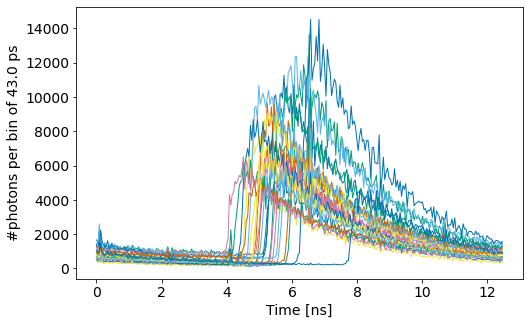

In [13]:
MM = nbins
laserF = laser_Hz # laser frequency (Hz)
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,5))
for det in range(Ndet):
    macroTime = getattr(data, "det" + str(det))[:,0] # ps
    microTime = getattr(data, "det" + str(det))[:,1]
    microTime = np.mod(microTime, 1e12 / laserF)
    microTime_flipped = -copy.deepcopy(microTime) + np.max(microTime)
    [Ihist, lifetimeBins] = np.histogram(microTime_flipped, MM)
    lifetimeBins = lifetimeBins[0:-1] * data.microtime * 1e12
    setattr(data, "hist" + str(det), np.transpose(np.stack((lifetimeBins, Ihist))))
    setattr(data, "det" + str(det), np.transpose([macroTime, microTime_flipped]))
    lifetimeBinsN = (lifetimeBins - lifetimeBins[0]) / lifetimeBins[1]
    plt.plot(1e-3*lifetimeBins, Ihist, linewidth=lineW)

data.microbintime = 1e-12 * lifetimeBins[1] # s
plt.xlabel("Time [ns]")
output = plt.ylabel("#photons per bin of " + '{:.1f}'.format(lifetimeBins[1]) + " ps")

## Align lifetime histograms

In [14]:
data = alignLifetimeHist(data)

In [15]:
plt.rcParams.update({'font.size': fontSize})
plt.style.use("seaborn-colorblind")
lineW = 1

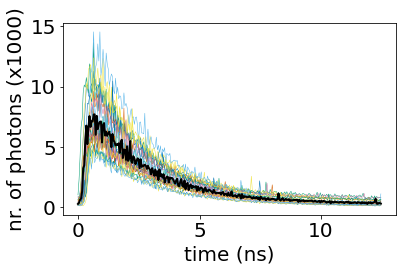

In [16]:
plt.figure()
#plt.margins(0,0)
for det in range(Ndet):
    histD = getattr(data, "Ahist" + str(det))
    if det != 10:
        plt.plot(1e-3*lifetimeBins, histD[:,1]/1000, linewidth=0.5)

histD = getattr(data, "Ahist" + str(10))
plt.plot(1e-3*lifetimeBins, histD[:,1]/1000, linewidth=lineW*2, color='black')
        

plt.xlabel("time (ns)")
#plt.axis([0, 25, 0, 3600/1000])
output = plt.ylabel("nr. of photons (x1000)") # of 43.4 ps
plt.rcParams['svg.fonttype'] = 'none'
plt.tight_layout()
plt.savefig('FLFS_histograms.svg')

## Crop first and last part of microtime histograms to calculate lifetimes and filter functions

In [17]:
# find index peak and zoom
Tmax = 210 # 210
fitRange = np.zeros((Ndet, 2), dtype='int')
for det in range(Ndet):
    IhistSingle = getattr(data, "hist" + str(det)) # number of photons per bin of 43.4 ps as a function of time in ps
    Ihist = IhistSingle[:, 1]
    idxStart = np.where(Ihist == np.max(Ihist))[0][0] + 1
    idxStop = np.where(Ihist[Tmax:] == np.min(Ihist[Tmax:]))[0][0] + Tmax + 1
    idxStop = np.minimum(idxStop, len(Ihist) - 1)
    fitRange[det, :] = [idxStart, idxStop]
    T = idxStop - idxStart
    # print("T = " + str(T))
data.fitRange = fitRange

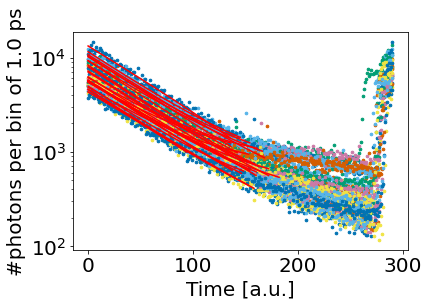

In [18]:
fitresults = np.zeros((Ndet, 3))

plt.figure()
for det in range(Ndet):
    # get histogram detector element i
    IhistSingle = getattr(data, "hist" + str(det)) # number of photons per bin of 43.4 ps as a function of time in ps
    Ihist = IhistSingle[:, 1]
    lifetimeBins = IhistSingle[:, 0]
    binTime = lifetimeBins[1]
    lifetimeBins /= binTime # bin numbers
    
    [idxStart, idxStop] = data.fitRange[det, :]
    fitRangeL = idxStop - idxStart
    
    Ihist = np.roll(Ihist, -idxStart)
    #lifetimeBins = np.roll(lifetimeBins, -idxStart)
    
    lifetimeBinsFit = (lifetimeBins[0:fitRangeL])
    IhistFit = Ihist[0:fitRangeL]
    
    plt.scatter(lifetimeBins, Ihist, s=7)
    plt.xlabel("Time [a.u.]")
    plt.ylabel("#photons per bin of " + '{:.1f}'.format(lifetimeBins[1]) + " ps")
    #plt.xlim([0, lifetimeBinsFit[-1]])

    # fit exponential
    
    fitresult = fitPowerLaw(IhistFit, lifetimeBinsFit, 'exp', [1, 1, 1], [60000, 4, 100], [0, 0, -1e4], [1e6, 20, 1e6])
    A      = fitresult.x[0]
    alpha  = fitresult.x[1]
    B      = fitresult.x[2]
    plt.plot(lifetimeBinsFit, A * np.exp(-alpha * lifetimeBinsFit) + B, color='r')
    plt.yscale('log')
    
    fitresults[det, :] = [A, alpha, B]
    # output = plt.title("A = " + '{:.0f}'.format(A) + "  -  tau = " + '{:.3f}'.format(1/alpha) + "  -  B = " + '{:.5f}'.format(B/A))

In [19]:
print("lifetime = (" + '{:.2f}'.format(np.mean(1e9*data.microbintime/fitresults[:, 1])) + " +/- " + '{:.2f}'.format(np.std(1e9*data.microbintime/fitresults[:, 1])) + ") ns")

lifetime = (2.57 +/- 0.10) ns


## Calculate filter functions

### Theoretical filter assuming monoexponential decay + offset

In [20]:
data.fitRange

array([[136, 289],
       [152, 289],
       [127, 288],
       [141, 288],
       [117, 276],
       [152, 290],
       [135, 290],
       [153, 290],
       [123, 290],
       [128, 290],
       [118, 282],
       [143, 289],
       [154, 290],
       [142, 285],
       [154, 284],
       [135, 290],
       [130, 290],
       [117, 286],
       [116, 289],
       [111, 284],
       [118, 272],
       [106, 289],
       [129, 290],
       [136, 285],
       [190, 285]])

In [21]:
data.fitRange[:,1] = 400

In [22]:
A = fitresults[:, 0]
alpha = fitresults[:, 1]
B = fitresults[:, 2]

In [23]:
data.fitRange[data.fitRange > len(Ihist)] = len(Ihist)

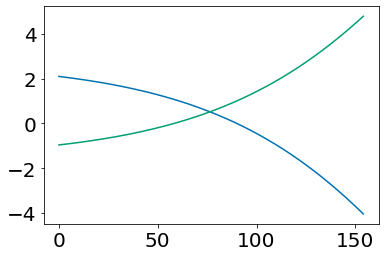

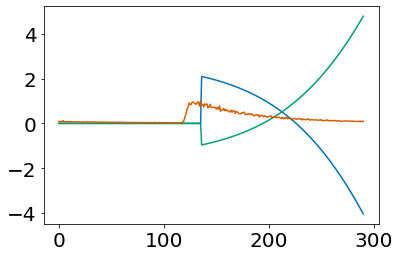

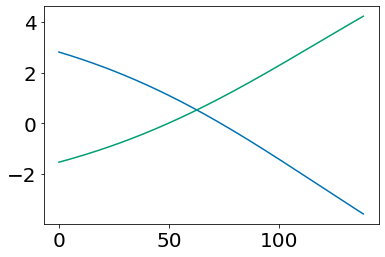

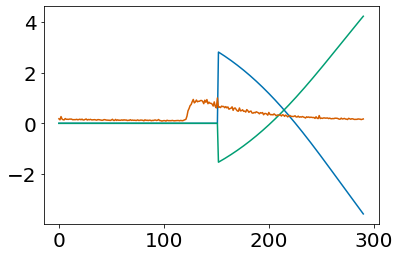

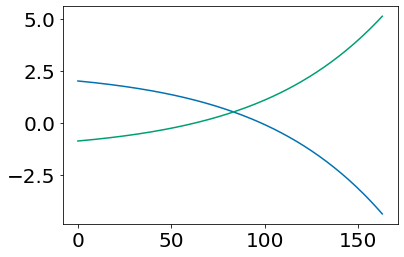

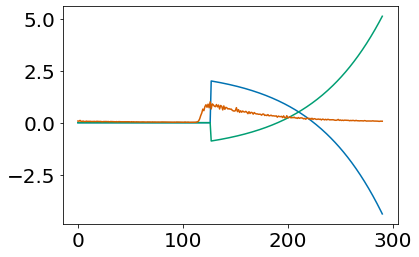

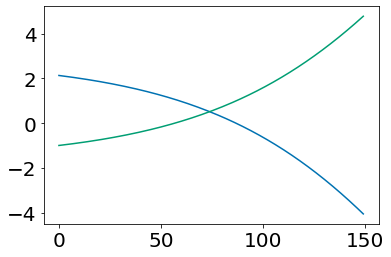

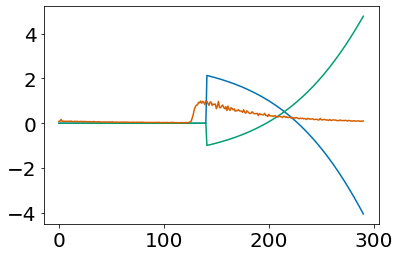

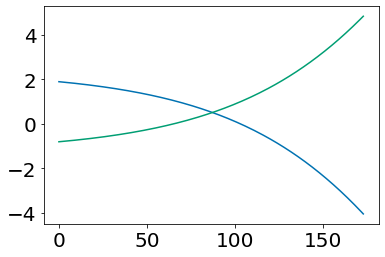

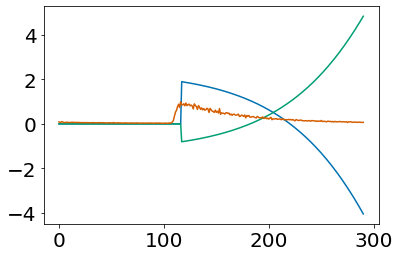

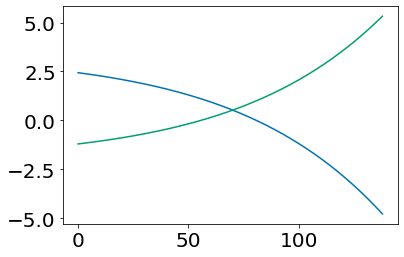

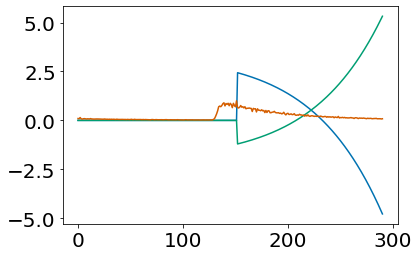

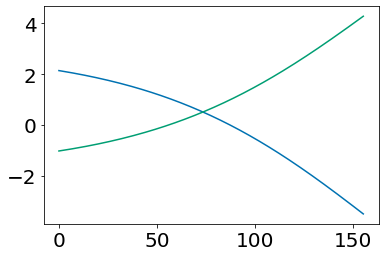

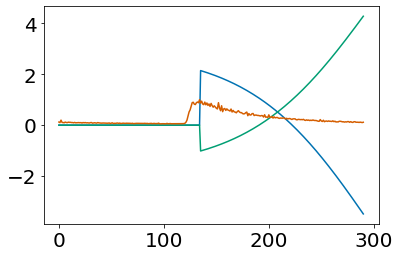

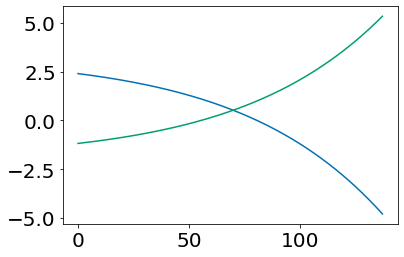

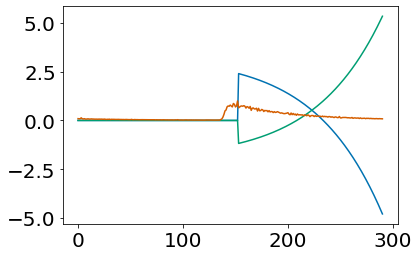

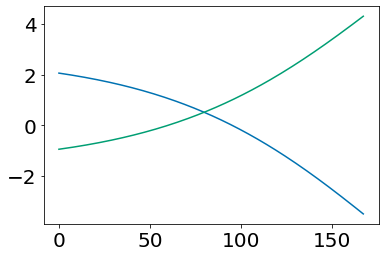

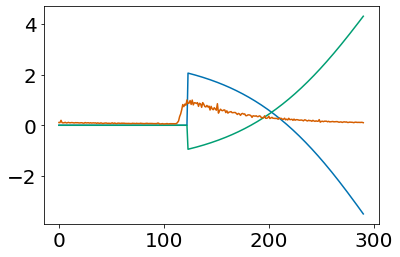

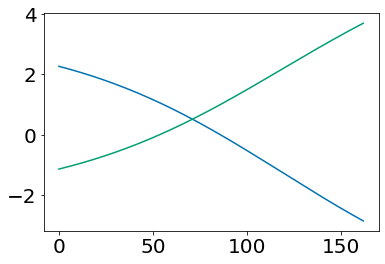

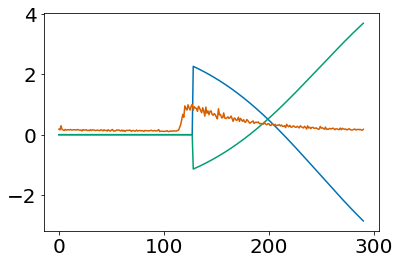

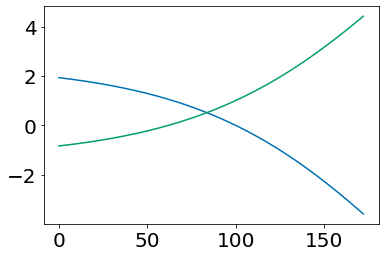

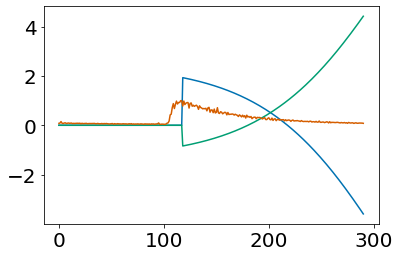

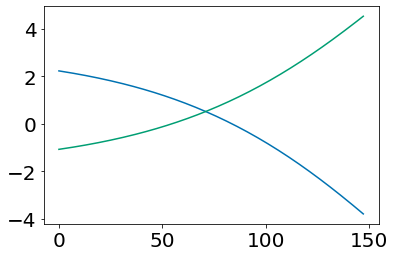

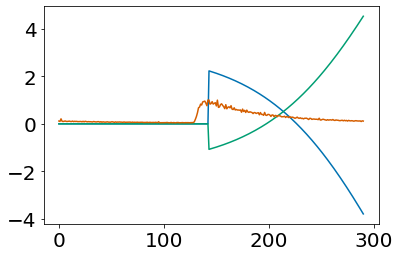

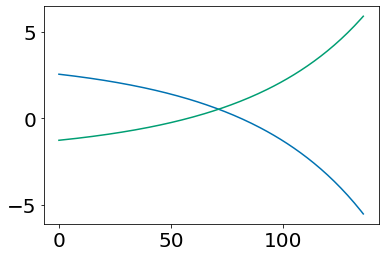

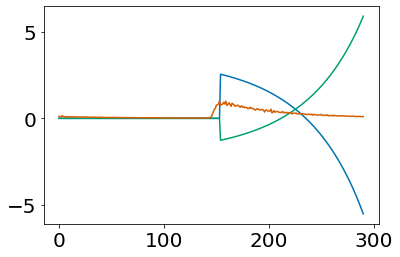

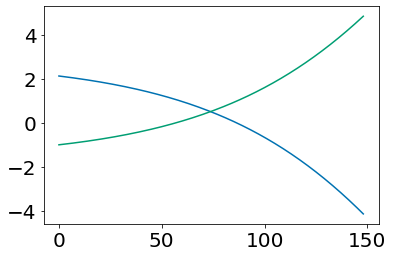

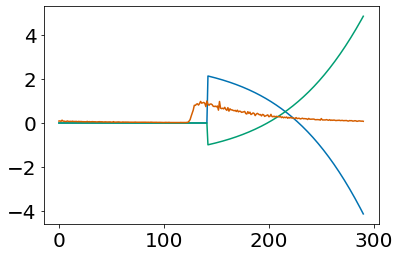

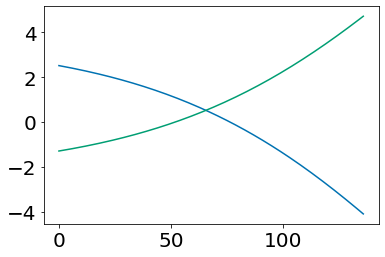

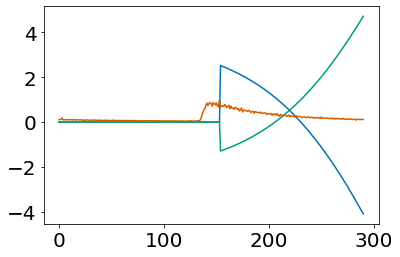

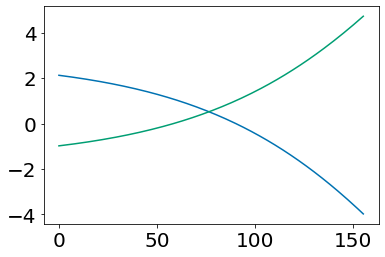

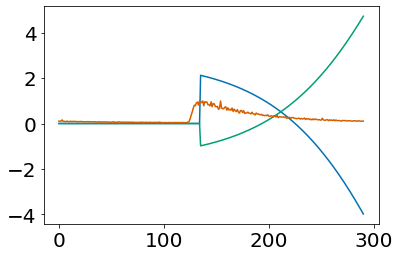

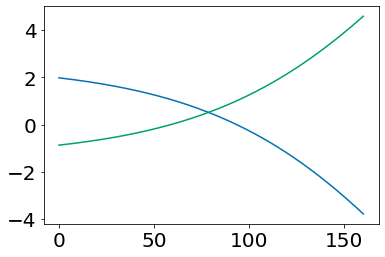

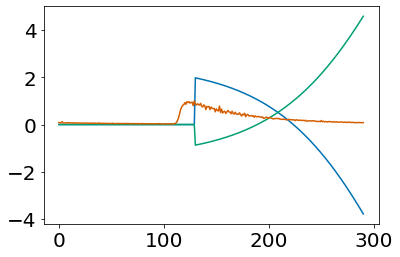

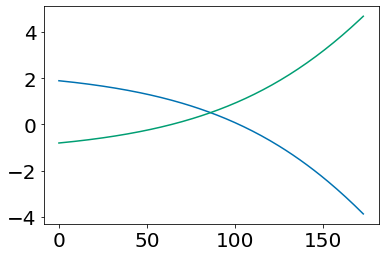

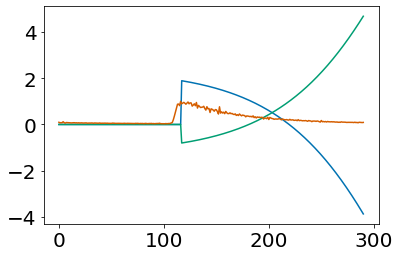

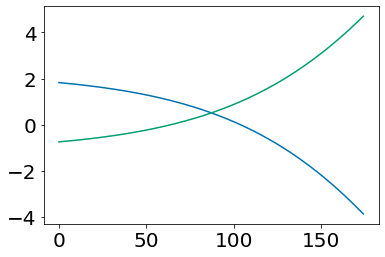

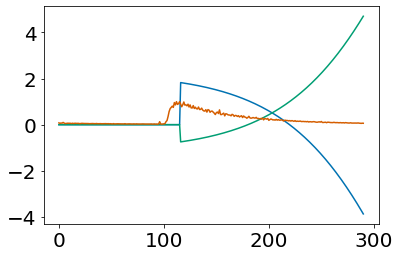

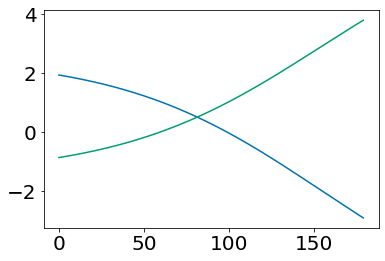

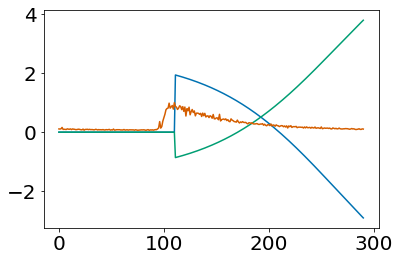

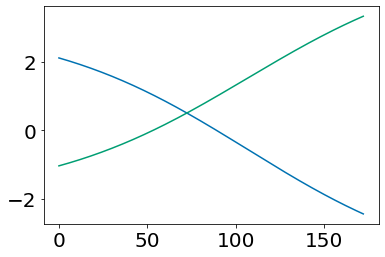

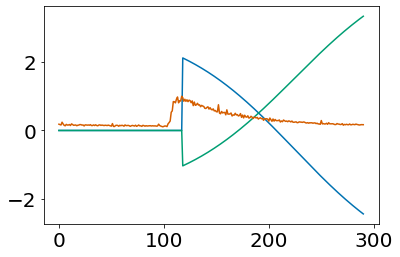

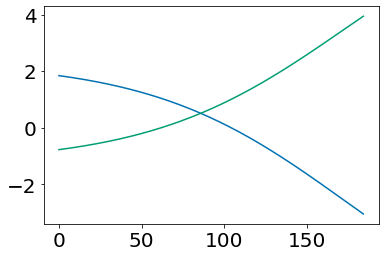

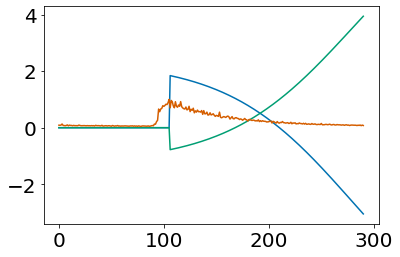

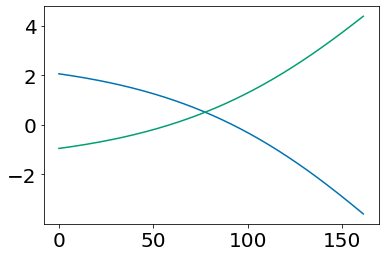

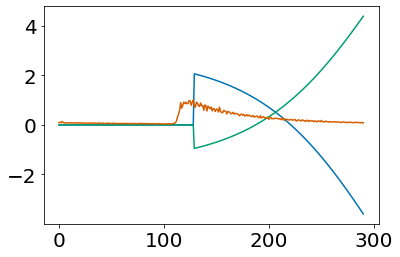

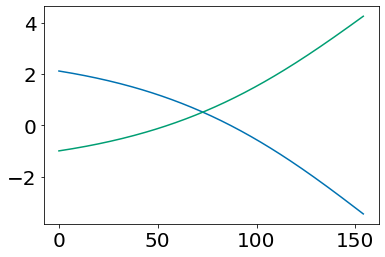

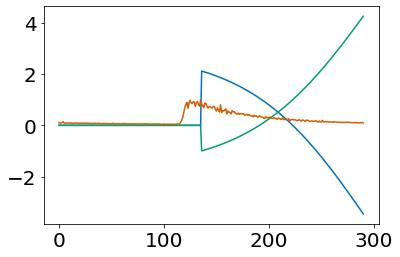

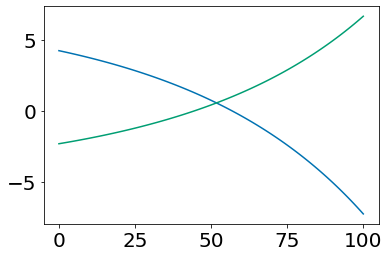

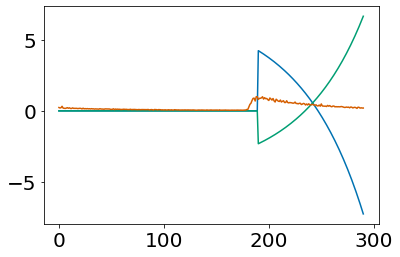

In [29]:
# filtersTheo contains all filters [det element, filtervalues, filter number]
filtersTheo = np.zeros((Ndet, len(Ihist), 2))
for det in range(Ndet):
    # calculate filter 
    tau = 1 / alpha[det]
    T = int(np.diff(data.fitRange[det, :]))
    offset = B[det] / A[det] # relative offset, wrt amplitude
    Ftheo = filterAP(0, tau, T, offset, False)
    
    # pad zeros before and after filter domain
    [startIdx, stopIdx] = data.fitRange[det, :]
    filtersTheo[det, startIdx:stopIdx, :] = np.transpose(Ftheo)
    
    # figure
    histSingle = getattr(data, 'hist' + str(det))
    histSingle[:,1] /= np.max(histSingle[:,1])
    plt.figure()
    plt.plot(filtersTheo[det, :, 0])
    plt.plot(filtersTheo[det, :, 1])
    plt.plot(histSingle[:,1])

In [30]:
lifetimeBins_plot = lifetimeBins*binTime

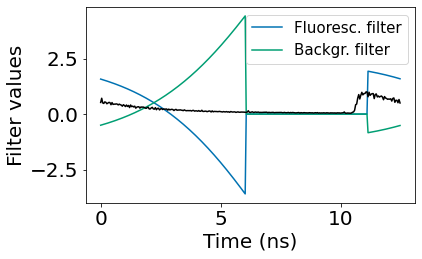

In [ ]:
histSingle = getattr(data, 'hist' + str(10))
histSingle[:,1] /= np.max(histSingle[:,1])

plt.figure()
roll = -150
plt.plot(1e-3*lifetimeBins_plot, np.roll(filtersTheo[10, :, 0], roll), label='Fluoresc. filter')
plt.plot(1e-3*lifetimeBins_plot, np.roll(filtersTheo[10, :, 1], roll), label='Backgr. filter')
plt.plot(1e-3*lifetimeBins_plot, np.roll(histSingle[:,1], roll), color='black')
plt.legend(fontsize=15)
plt.xlabel("Time (ns)")
plt.ylabel('Filter values')
# plt.axis([0, 25, -1.4, 2.4])
plt.rcParams['svg.fonttype'] = 'none'
plt.tight_layout()
plt.savefig('FLFS_filters.svg', bbox_inches='tight')

### Filter using theoretical filter functions

In [ ]:
data = aTimesFiltered(data, filtersTheo, False)

Calculating filtered photon streams det0
Calculating filtered photon streams det1
Calculating filtered photon streams det2
Calculating filtered photon streams det3
Calculating filtered photon streams det4
Calculating filtered photon streams det5
Calculating filtered photon streams det6
Calculating filtered photon streams det7
Calculating filtered photon streams det8
Calculating filtered photon streams det9
Calculating filtered photon streams det10
Calculating filtered photon streams det11
Calculating filtered photon streams det12
Calculating filtered photon streams det13
Calculating filtered photon streams det14
Calculating filtered photon streams det15
Calculating filtered photon streams det16
Calculating filtered photon streams det17
Calculating filtered photon streams det18
Calculating filtered photon streams det19
Calculating filtered photon streams det20
Calculating filtered photon streams det21
Calculating filtered photon streams det22
Calculating filtered photon streams det23
Ca

In [ ]:
G = aTimes2CorrsParallel(data, list(range(0, nchannel)), accuracy=100, taumax=1/data.macrotime, split=10)

Calculating correlation 0
   Filter 0
   Filter 1
   Filter 2
Calculating correlation 1
   Filter 0
   Filter 1
   Filter 2
Calculating correlation 2
   Filter 0
   Filter 1
   Filter 2
Calculating correlation 3
   Filter 0
   Filter 1
   Filter 2
Calculating correlation 4
   Filter 0
   Filter 1
   Filter 2
Calculating correlation 5
   Filter 0
   Filter 1
   Filter 2
Calculating correlation 6
   Filter 0
   Filter 1
   Filter 2
Calculating correlation 7
   Filter 0
   Filter 1
   Filter 2
Calculating correlation 8
   Filter 0
   Filter 1
   Filter 2
Calculating correlation 9
   Filter 0
   Filter 1
   Filter 2
Calculating correlation 10
   Filter 0
   Filter 1
   Filter 2
Calculating correlation 11
   Filter 0
   Filter 1
   Filter 2
Calculating correlation 12
   Filter 0
   Filter 1
   Filter 2
Calculating correlation 13
   Filter 0
   Filter 1
   Filter 2
Calculating correlation 14
   Filter 0
   Filter 1
   Filter 2
Calculating correlation 15
   Filter 0
   Filter 1
   Filter 2
Ca

['/home/mdonato-fast/data/forNBv2/DatiForRep/FCS/09_cell2_FCS', 'h5']

 fname[0:-3]Store correlations to .csv files

In [41]:
corr2csv(G, filenameHDF5[0:-3], limits=[0, 0], chunks=0)

In [42]:
data_head_raw, data_filename_raw = os.path.split(filenameHDF5)

Load correlations from .csv files

In [43]:
G = FCSLoadG(data_filename_raw[0:-3] + '_', folderName=data_head_raw, printFileNames=True)

det0F2_average
det0F1_average
det22F1_average
det11F2_average
det16F2_average
det3F1_average
det12F2_average
det18F0_average
det15F1_average
det10F0_average
det22F2_average
det9F0_average
det0F0_average
det5F2_average
det6F2_average
det3F2_average
det11F1_average
det20F0_average
det21F1_average
det15F0_average
det10F1_average
det16F0_average
det12F1_average
det24F2_average
det19F2_average
det9F1_average
det21F2_average
det1F0_average
det17F2_average
det6F0_average
det13F1_average
det19F1_average
det23F2_average
det7F1_average
det14F0_average
det7F2_average
det8F0_average
det6F1_average
det5F1_average
det12F0_average
det23F1_average
det9F2_average
det10F2_average
det13F2_average
det11F0_average
det2F2_average
det17F0_average
det18F1_average
det1F2_average
det1F1_average
det20F1_average
det13F0_average
det3F0_average
det20F2_average
det18F2_average
det4F2_average
det5F0_average
det7F0_average
det2F0_average
det8F2_average
det14F1_average
det17F1_average
det24F0_average
det15F2_average
de

## Plot correlations

/home/mdonato/.local/lib/python3.8/site-packages/spad_fcs/FCS2Corr.py:568: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  h = plt.figure()


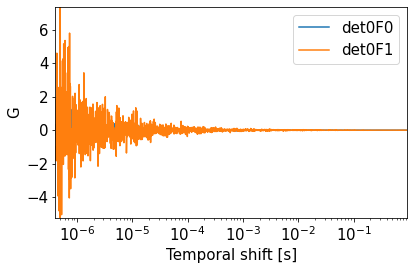

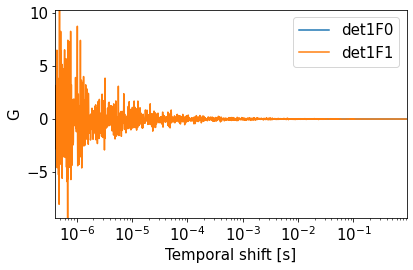

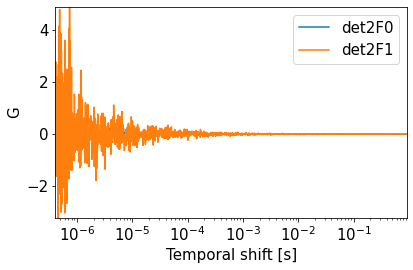

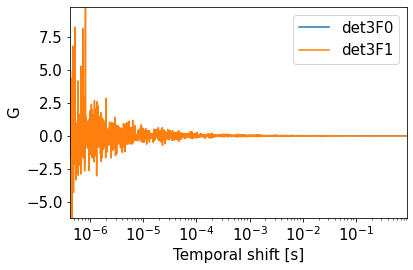

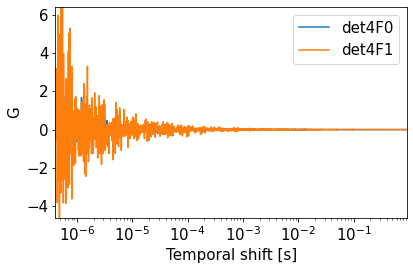

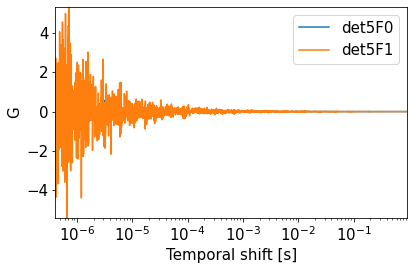

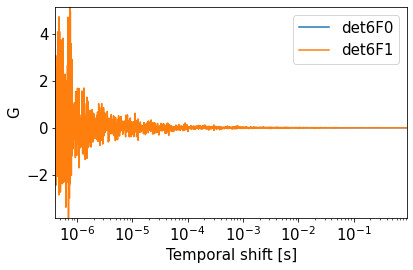

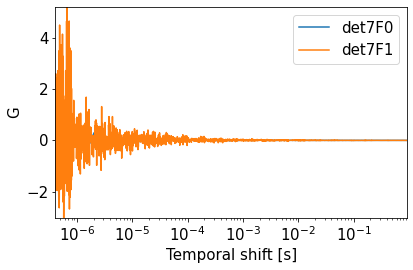

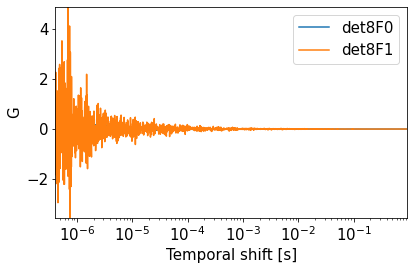

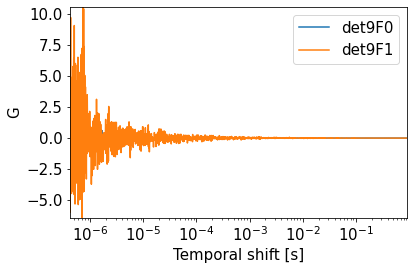

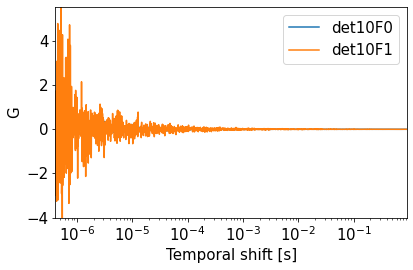

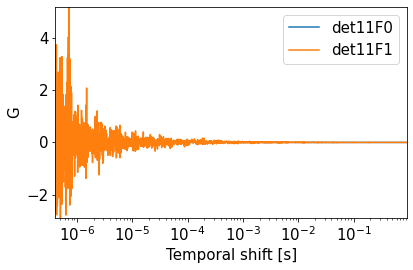

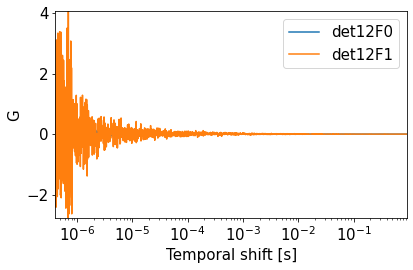

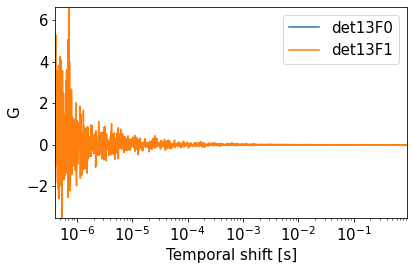

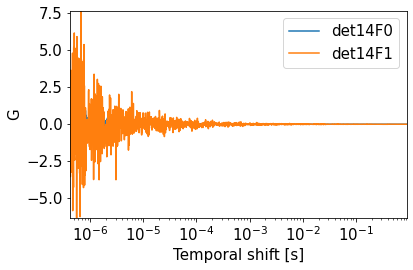

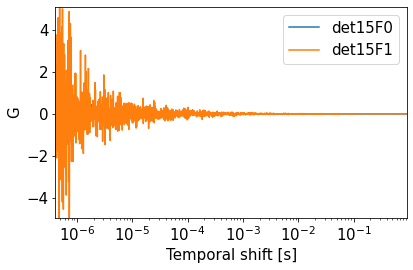

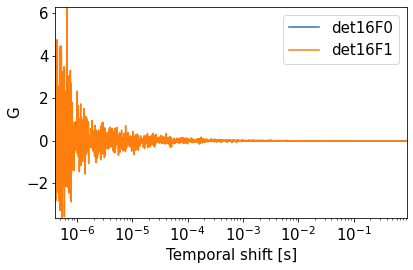

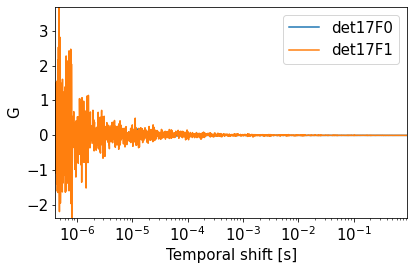

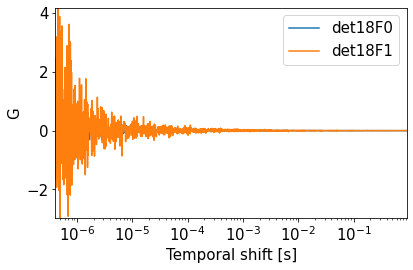

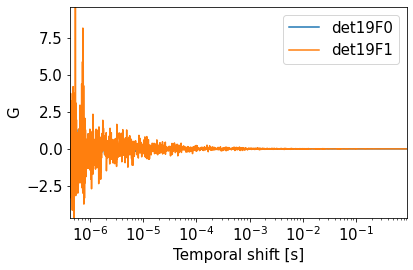

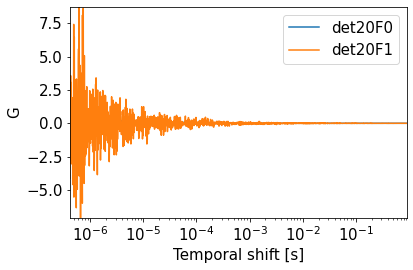

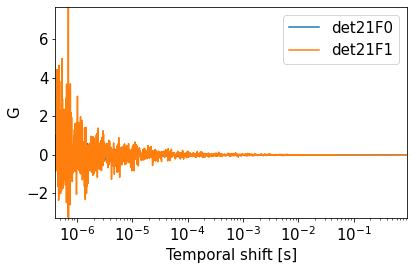

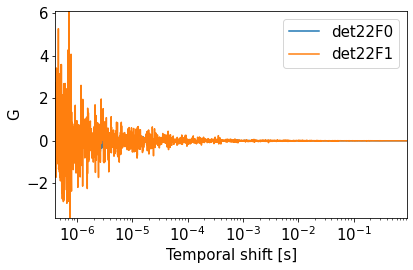

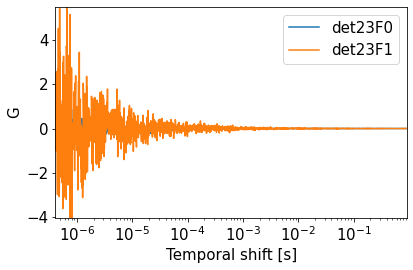

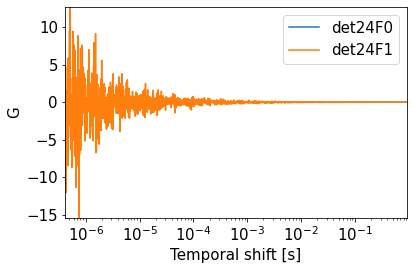

In [44]:
start = 1200
stop = -10
for i in range(nchannel):
    h = plotFCScorrelations(G, ['det'+str(i)+'F0_average','det'+str(i)+'F1_average'], limits=[start, stop], pColors=[0, 1, 2])

## Fit correlations unfiltered data

------
0.009932111872
saving figure
tauD = 5.000000000000001e-06 ms
chi2 = 4.943431397827263
fitresult[0] = 0.007358210254152872
fitresult[1] = 5.000000000000001e-06
fitresult[2] = 1.0000000000000001e-07
4.999999999999999e-07
diameter: 8.584393564365239e-13


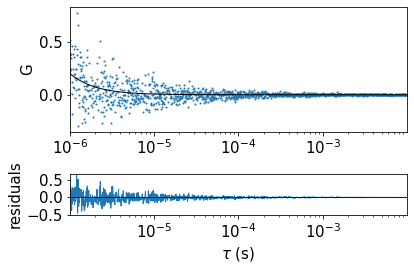

In [45]:
SF = 4.5 # shape parameter for the PSF
amp = 1 # start value for the amplitude of the correlation function
w0 = 220e-9 # start value for the beam waist
Gfit = "det10F0_average"

fitresults = np.zeros((1, 3))
color = "C0"
color = 0

dataSingle = getattr(G, Gfit)
dataSingleF = getattr(G, Gfit)
tau = dataSingle[:,0]
Gexp = dataSingle[:,1]
GexpF = dataSingleF[:,1]

[dummy, start] = findNearest(tau,1e-6)
[dummy, stop] = findNearest(tau,1e-2)

fitarray = np.array([1, 1, 1, 0, 0, 0, 0])
paramStart = np.array([amp, 2.4, 300e-9, SF, 0.5e-6, 320e-6, 0])
paramMin = np.array([0, 5e-6, 100e-9, 3, 0, 0, -1])
paramMax = np.array([1e6, 10, 10000e-9, 6, 10, 10, 1])
                            #  [N, tauD, w, SF, Rcirc, Tcirc, offset]
fitresult = FCSfit(Gexp[start:stop],  tau[start:stop], 'fitfunCircFCS', fitarray, paramStart,  paramMin, paramMax, color, 0, savefig=Gfit+'.svg', plotTau=False)
for l in range(sum(fitarray)):
    print("fitresult[" + str(l) + "] = " + str(fitresult.x[l]))
D = fitresult.x[2]**2 / 4 / (fitresult.x[1]*1e-3)
print(D)
print("diameter: " + str(StokesEinstein(D)))
color += 1
fitresults[0, :] = fitresult.x